In [2]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="extraconnsdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [3]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

more_provisioned_custom_mpm_server_200conns_1client_1attackers_newreala


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,more_provisioned_custom_mpm_server_200conns_1c...,1,4,1,originserver,microcloud,ubuntu1804-std
1,more_provisioned_custom_mpm_server_200conns_1c...,1,6,2,receiver,microcloud,ubuntu1804-std
2,more_provisioned_custom_mpm_server_200conns_1c...,1,1,3,attacker,microcloud,ubuntu1804-std
3,more_provisioned_custom_mpm_server_200conns_1c...,1,5,4,proxy,microcloud,ubuntu1804-std
4,more_provisioned_custom_mpm_server_200conns_1c...,1,2,5,client1,microcloud,ubuntu1804-std


In [4]:
exp_id = "more_provisioned_custom_mpm_server_200conns_1client_1attackers_newreala"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'attacker': 3, 'client1': 5, 'originserver': 1, 'proxy': 4, 'receiver': 2}
{'attacker': 1, 'client1': 2, 'originserver': 4, 'proxy': 5, 'receiver': 6}
{5}
{2}
4


In [5]:
summary_sql = f"""
SELECT 
	n.node_name AS observer,
	e.trial,
	COUNT (DISTINCT e.message_marker) AS unique_messages,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec
FROM 
	deployed_node d 
	JOIN node n ON n.node_id = d.node_id
	JOIN "event" e ON e.observer_id = d.dnid
WHERE 
	d.exp_id = '{exp_id}'
GROUP BY
	n.node_name,
	e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
con.commit()
sdf

,observer,trial,unique_messages,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
0,attacker,1,520209,520209,1.642191e+09,1.642191e+09,19.835135
1,client1,1,385,775,1.642191e+09,1.642191e+09,80.220929
2,originserver,1,271325,544351,1.642191e+09,1.642191e+09,101.268815
3,proxy,1,520595,1507128,1.642191e+09,1.642191e+09,101.443147
4,receiver,1,442313,442313,1.642191e+09,1.642191e+09,80.318236


In [6]:
client_messages_sql = f"""
SELECT
    e.observe_timestamp,
    e.message_marker,
    e.trial,
	m.src_id,
	m.dst_id,
    m.size_bytes
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))})
ORDER BY
    e.observe_timestamp
;
"""

df = pd.read_sql_query(client_messages_sql, con)
con.commit()

# Negate timestamp of client src message to measure RTT
df["observe_timestamp"] = df.where(df["dst_id"].isin(client_node_ids), df["observe_timestamp"] * -1, axis=0)

rtts_df = df.groupby(by=["trial", "message_marker"]).agg(\
                                              rtt_sec=("observe_timestamp", "sum"), 
                                              timestamp=("observe_timestamp", "max"),
                                              src_id=("src_id", "max"),
                                              max_size_bytes=("size_bytes", "max")).reset_index()
rtts_df = rtts_df[rtts_df["rtt_sec"] > 0]
rtts_df["rtt_ms"] = rtts_df["rtt_sec"] * 1e3

rps_records = []

for t in rtts_df["trial"].unique():
    print(f"Trial {t}")
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        print(f"-- Client {client_number}")
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        client_trial_df["count"] = np.arange(1, len(client_trial_df) + 1)
        print(client_trial_df.describe())
        average_rps = client_trial_df["count"].max() / (client_trial_df["timestamp"].max() - client_trial_df["timestamp"].min())
        print(f"\naverage_rps={average_rps}")
        print()
        
        rps_records.append({
            "trial": t, 
            "src_id": src_id,
            "client_number": client_number,
            "average_rps": average_rps,
        })

# Add average rps per client per trial to the rtts df
rps_df = pd.DataFrame.from_records(rps_records)
rtts_df = rtts_df.merge(rps_df[["trial", "src_id", "average_rps"]], on=["trial", "src_id"], how="left")
        
rtts_df

Trial 1
-- Client 1
       trial  message_marker     rtt_sec     timestamp  src_id  \
count  383.0      383.000000  383.000000  3.830000e+02   383.0   
mean     1.0      199.060052    0.055857  1.642191e+09     5.0   
std      0.0      184.527454    0.040138  6.014008e+00     0.0   
min      1.0        1.000000    0.052706  1.642191e+09     5.0   
25%      1.0       96.500000    0.052912  1.642191e+09     5.0   
50%      1.0      192.000000    0.053042  1.642191e+09     5.0   
75%      1.0      287.500000    0.053354  1.642191e+09     5.0   
max      1.0     3087.000000    0.819826  1.642191e+09     5.0   

       max_size_bytes      rtt_ms      count  
count      383.000000  383.000000  383.00000  
mean       107.718016   55.856654  192.00000  
std          0.500120   40.137741  110.70682  
min        106.000000   52.706242    1.00000  
25%        107.000000   52.912235   96.50000  
50%        108.000000   53.041935  192.00000  
75%        108.000000   53.354025  287.50000  
max      

,trial,message_marker,rtt_sec,timestamp,src_id,max_size_bytes,rtt_ms,average_rps
0,1,1,0.195108,1.642191e+09,5,106,195.108175,17.674454
1,1,2,0.055473,1.642191e+09,5,106,55.473089,17.674454
2,1,3,0.054818,1.642191e+09,5,106,54.818153,17.674454
3,1,4,0.055299,1.642191e+09,5,106,55.299044,17.674454
4,1,5,0.054767,1.642191e+09,5,106,54.766893,17.674454
...,...,...,...,...,...,...,...,...
378,1,379,0.052957,1.642191e+09,5,108,52.957058,17.674454
379,1,380,0.052987,1.642191e+09,5,108,52.986860,17.674454
380,1,381,0.052799,1.642191e+09,5,108,52.798986,17.674454
381,1,382,0.154073,1.642191e+09,5,108,154.073000,17.674454


In [7]:
rtts_df["rtt_ms"].describe()

count    383.000000
mean      55.856654
std       40.137741
min       52.706242
25%       52.912235
50%       53.041935
75%       53.354025
max      819.826126
Name: rtt_ms, dtype: float64

<IPython.core.display.Javascript object>


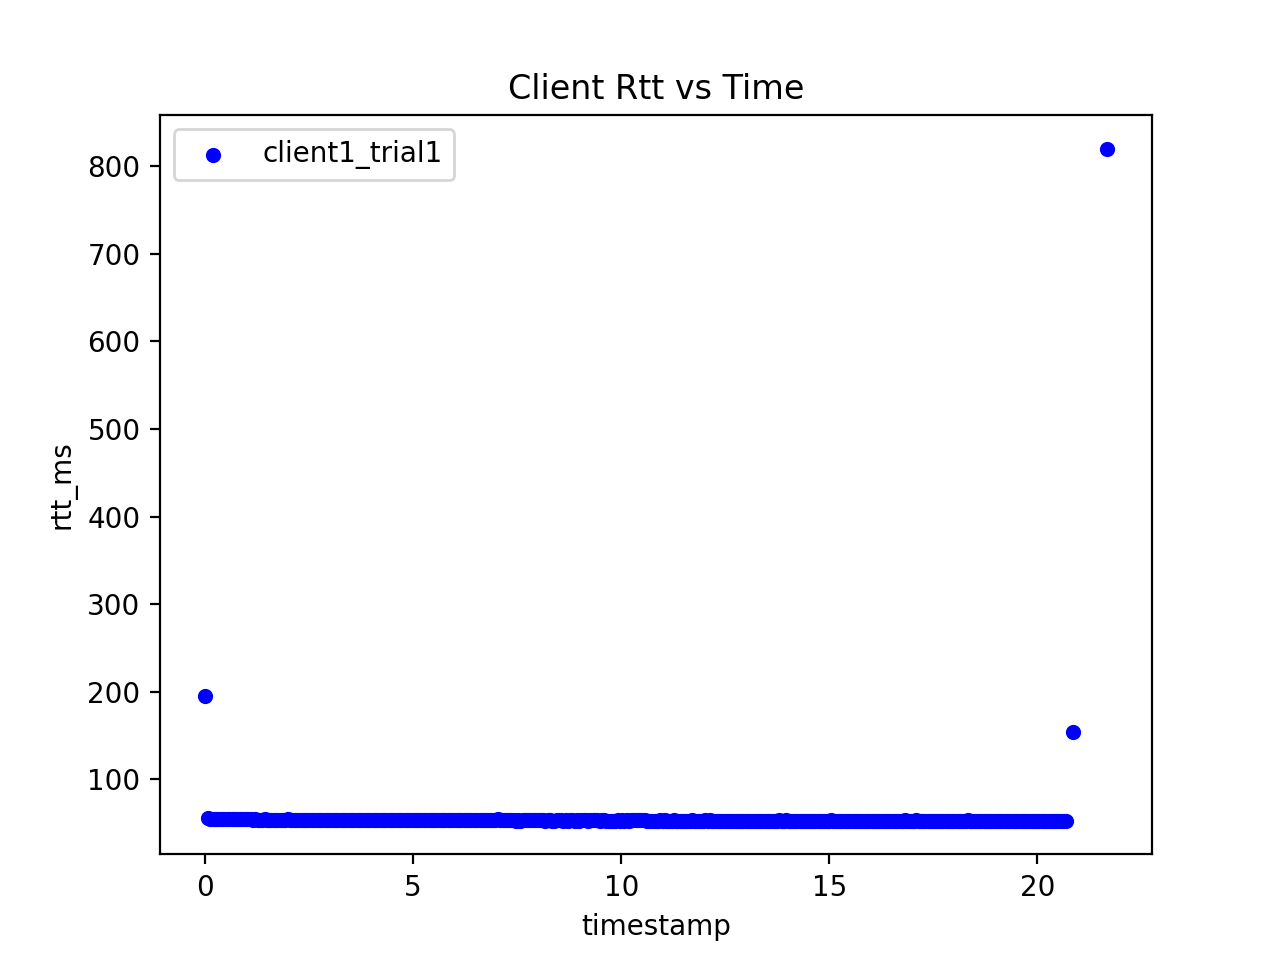

In [13]:
%matplotlib notebook
%matplotlib notebook

ignore_clients = {}
ignore_trials = {}

ax = None
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        if ax:
            client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, ax=ax, color=color_map[(client_number, t)])
        else:
            ax = client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, color=color_map[(client_number, t)])

ax.set_title("Client Rtt vs Time")            
plt.show()

<IPython.core.display.Javascript object>


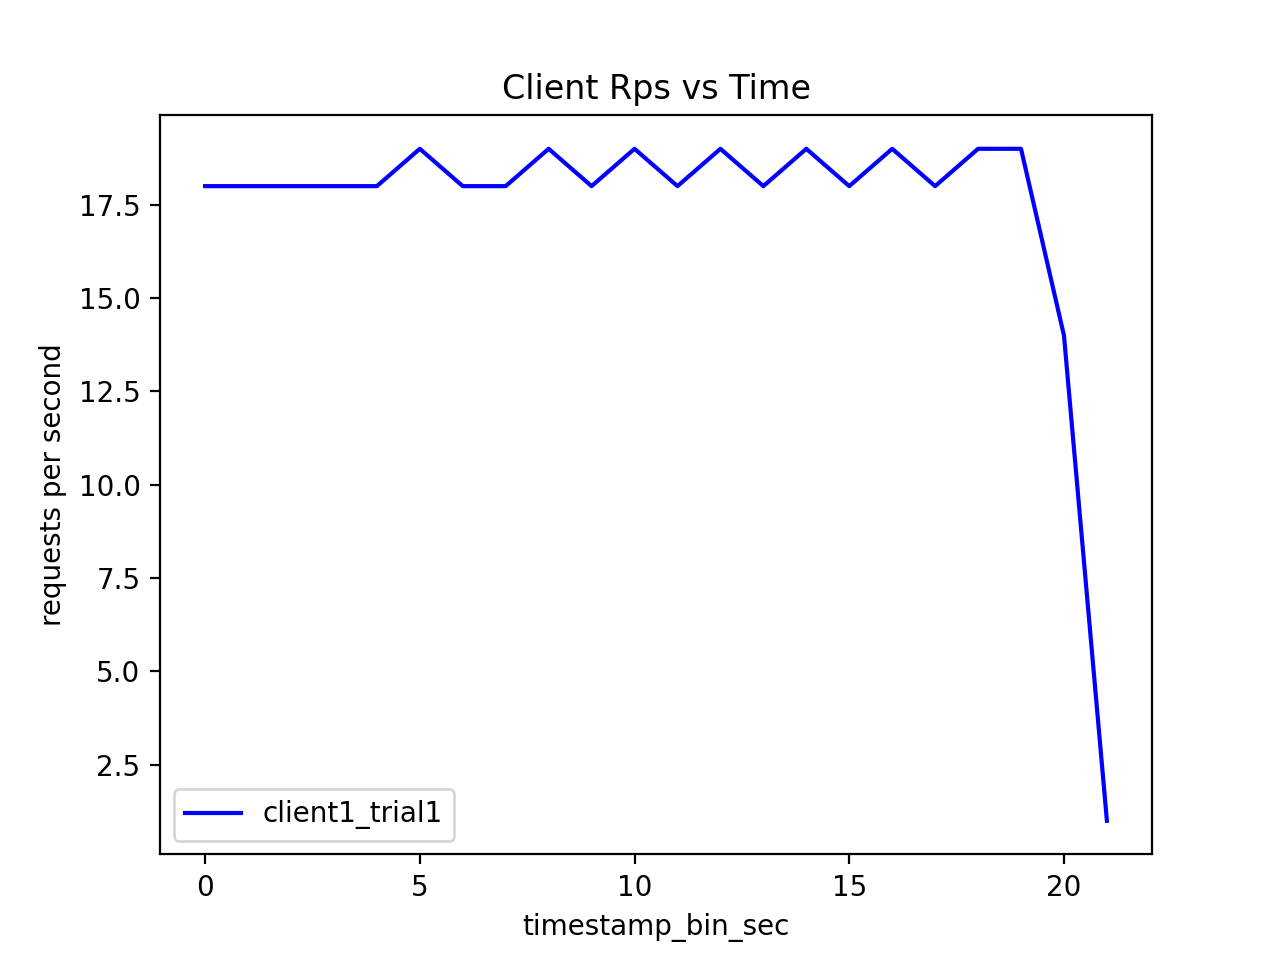

,timestamp_bin_sec,src_id,packets_per_second,bytes_per_second
0,0.0,5,18,1917
1,1.0,5,18,1926
2,2.0,5,18,1926
3,3.0,5,18,1926
4,4.0,5,18,1926
5,5.0,5,19,2043
6,6.0,5,18,1944
7,7.0,5,18,1944
8,8.0,5,19,2052
9,9.0,5,18,1944


In [14]:
%matplotlib notebook
%matplotlib notebook

trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "src_id"]).agg(\
                                             packets_per_second=("max_size_bytes", "count"),
                                             bytes_per_second=("max_size_bytes", "sum")).reset_index()
    
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[time_stats_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


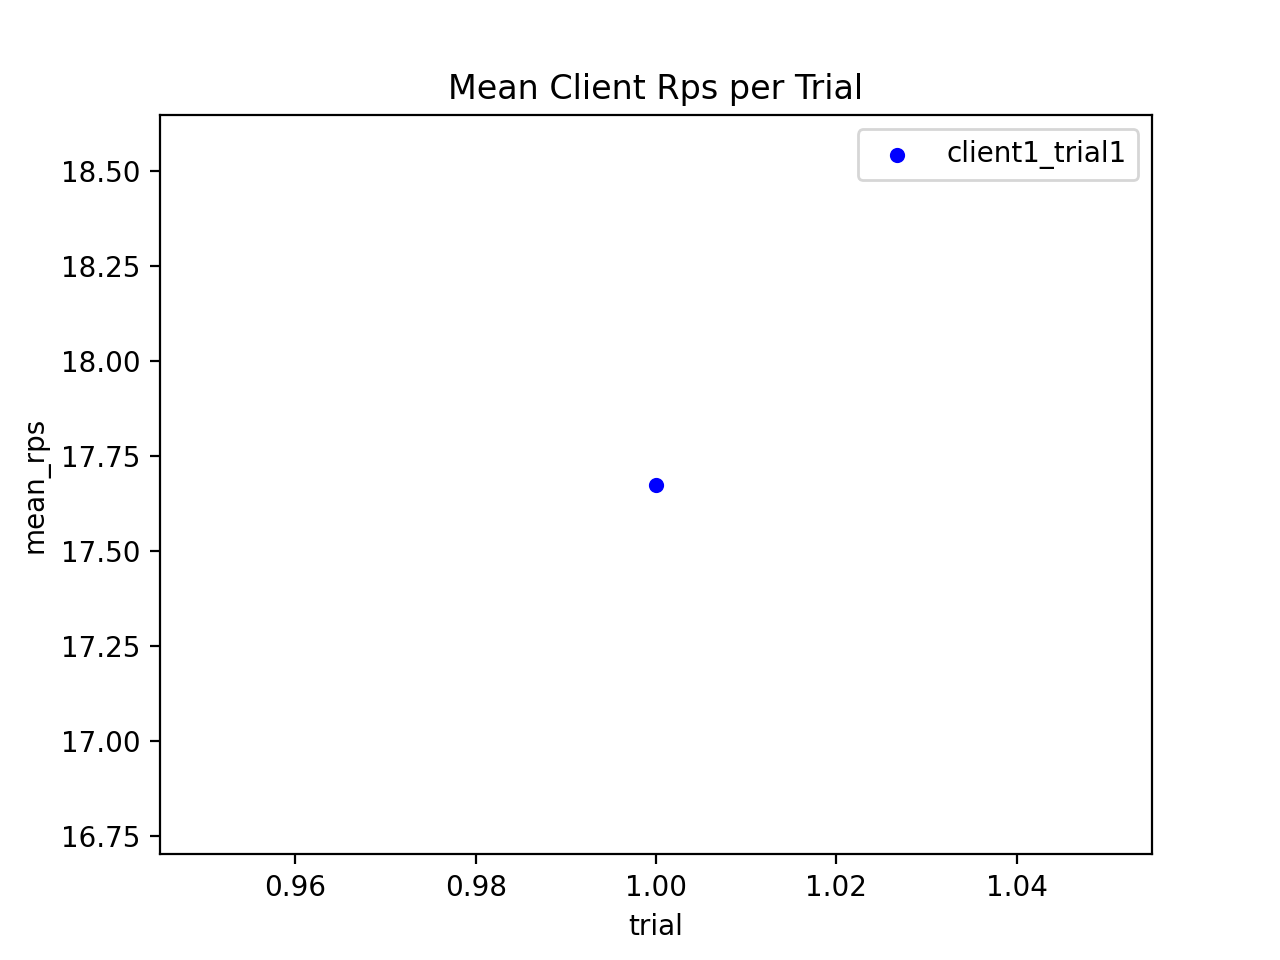

   trial   mean_rps
0      1  17.674454


,src_id,trial,mean_rps
0,5,1,17.674454


In [15]:
gdf = rtts_df.groupby(by=["src_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["src_id"].unique(), start=1):
        cdf = tdf[tdf["src_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

gdf

In [16]:
# # Obsolete?
# # Dataframe of attacker message RTT from attacker to receiver

# attacker_messages_sql = f"""
# WITH negate_attacker_timestamp AS (
# SELECT
#     e.trial,
# 	e.message_marker,
# 	e.observer_id,
# 	CASE WHEN e.observer_id={node_map_dnid['attacker']} THEN -1 * e.observe_timestamp
# 		 ELSE e.observe_timestamp
# 	END AS timestamp,
#     cm.coap_code
# FROM
# 	event e
# 	JOIN message m ON e.message_id = m.message_id
#     JOIN node ndst ON ndst.node_id = m.dst_id
#     JOIN coap_message cm ON cm.cmci = m.coap_message
# WHERE
# 	e.observer_id IN ({node_map_dnid['attacker']}, {node_map_dnid['receiver']})
# )

# SELECT 
# 	trial,
# 	message_marker,
# 	COUNT(timestamp) AS num_timestamps_should_be_2,
# 	MAX(timestamp) AS timestamp,
# 	SUM(timestamp) * 1e3 AS rtt_ms,
#     ARRAY_AGG(coap_code) AS coap_codes
# FROM 
# 	negate_attacker_timestamp
# GROUP BY
# 	trial,
# 	message_marker
# """

# adf = pd.read_sql_query(attacker_messages_sql, con)
# con.commit()

# adf["timestamp"] = abs(adf["timestamp"])
# adf = adf[adf["rtt_ms"] > 0]
# adf["coap_codes"] = adf["coap_codes"].astype(str)
# print(adf.info())
# print(adf.describe())

# # Ensure that content and bad gateway status codes fully partition attacker messages
# content_df = adf[adf["coap_codes"].str.contains("content")]
# gateway_df = adf[adf["coap_codes"].str.contains("bad_gateway")]
# assert len(content_df) + len(gateway_df) == len(adf)

# adf

In [17]:

trial_map_color = {1: "red", 2: "blue", 3:"green"}

ax = None
for t in adf["trial"].unique():
    trial_df = adf[adf["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    label = f"trial{t}"
    
    content_df = trial_df[trial_df["coap_codes"].str.contains("content")]
    color = trial_map_color[t]
    ax = content_df.sort_values(by="timestamp").plot(kind="line", x="timestamp", y="rtt_ms", ax=ax, label=label+"_2.05", color=color)
    
    gateway_df = trial_df[trial_df["coap_codes"].str.contains("bad_gateway")]
    color = trial_map_color[(t+1)%len(trial_map_color)]
    ax = gateway_df.sort_values(by="timestamp").plot(kind="line", x="timestamp", y="rtt_ms", ax=ax, label=label+"_5.02", color=color)
    
ax.set_ylabel("rtt in ms")
ax.set_title("Attacker Rtt Per Second")
plt.show()

trial_df

NameError: name 'adf' is not defined

In [18]:
ax = None
for t in adf["trial"].unique():
    trial_df = adf[adf["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec"]).agg(\
                                         packets_per_second=("message_marker", "count")).reset_index()

    
    label = f"trial{t}"
    ax = time_stats_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, label=label)
    
ax.set_ylabel("requests per second")
ax.set_title("Attacker Requests Per Second")
plt.show()

time_stats_df

NameError: name 'adf' is not defined

In [22]:
%matplotlib notebook
%matplotlib notebook

attack_dbg_sql = f"""

WITH proxy AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = 5 -- proxy is observer
), proxy_from_server AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = 13 AND dst_id = 16 -- server --> proxy
), proxy_from_attacker AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = 14 AND dst_id = 16 -- attacker (spoofing as receiver) --> proxy
), exp_server AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = 4 -- server is observer
), server_from_proxy AS (
SELECT 
	*
FROM 
	exp_server
WHERE
	src_id = 16 AND dst_id = 13 -- proxy --> server
), receiver AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = 6 -- receiver is observer
), experiment_timestamps AS (
SELECT 
	MIN(x.observe_timestamp) AS min_timestamp,
	MAX(x.observe_timestamp) AS max_timestamp
FROM 
	event x 
WHERE 
	x.observer_id = 5 OR x.observer_id = 2 -- proxy or client
), main_table AS (
SELECT 
	dn.exp_id,
	e.trial,
	e.message_marker,
	
	r.coap_type,
	r.coap_code,
	r.coap_retransmitted,
	
	sfp.src_id AS sfp_src_id,
	sfp.dst_id AS sfp_dst_id,
	
	e.observe_timestamp - min_timestamp   AS a_observe_timestamp,
	pfa.observe_timestamp - min_timestamp AS pfa_observe_timestamp,
	sfp.observe_timestamp - min_timestamp AS sfp_observe_timestamp,
	pfs.observe_timestamp - min_timestamp AS pfs_observe_timestamp,
	r.observe_timestamp - min_timestamp   AS r_observe_timestamp,
	
	1e3 * (pfa.observe_timestamp - e.observe_timestamp)   AS attacker_to_proxy_ms,
	1e3 * (sfp.observe_timestamp - pfa.observe_timestamp) AS proxy_to_server_ms,
	1e3 * (pfs.observe_timestamp - sfp.observe_timestamp) AS server_to_proxy_ms,
	1e3 * (r.observe_timestamp   - pfs.observe_timestamp) AS proxy_to_receiver_ms,
	1e3 * (r.observe_timestamp   - e.observe_timestamp)   AS attacker_to_receiver_ms
FROM
	event e
	JOIN deployed_node dn             ON dn.dnid            = e.observer_id
	LEFT JOIN proxy_from_attacker pfa ON pfa.message_marker  = e.message_marker
	LEFT JOIN server_from_proxy sfp   ON sfp.message_marker = e.message_marker
	LEFT JOIN proxy_from_server pfs   ON pfs.message_marker = e.message_marker
	LEFT JOIN receiver r              ON r.message_marker   = e.message_marker
	, experiment_timestamps
WHERE 
	e.observer_id = 1 -- attacker is observer for e
), main_table_summary AS (
	SELECT
		COUNT(DISTINCT x.message_marker) AS num_unique_messages,
		COUNT(x.message_marker) AS num_messages
	FROM
		main_table x
), massaged_main_table AS (
SELECT 
	mts.*,
	mt.*
FROM
	main_table mt,
	main_table_summary mts
ORDER BY
	mt.exp_id,
	mt.trial,
	mt.message_marker
), duplicate_messages AS (
SELECT a.*
FROM massaged_main_table a
JOIN (SELECT exp_id, trial, message_marker, COUNT(*)
FROM massaged_main_table 
GROUP BY exp_id, trial, message_marker
HAVING count(*) > 1 ) b
ON a.exp_id = b.exp_id
AND a.trial = b.trial
AND a.message_marker = b.message_marker
ORDER BY a.exp_id, a.trial, a.message_marker
)

SELECT *
FROM massaged_main_table 
;

"""

adbgdf = pd.read_sql_query(attack_dbg_sql, con)
adbgdf["sent_time_ms"] = adbgdf["a_observe_timestamp"]
adbgdf.sort_values(by="sent_time_ms", inplace=True)
con.commit()

adbgdf

,num_unique_messages,num_messages,exp_id,trial,message_marker,coap_type,coap_code,coap_retransmitted,sfp_src_id,sfp_dst_id,...,pfa_observe_timestamp,sfp_observe_timestamp,pfs_observe_timestamp,r_observe_timestamp,attacker_to_proxy_ms,proxy_to_server_ms,server_to_proxy_ms,proxy_to_receiver_ms,attacker_to_receiver_ms,sent_time_ms
0,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,383,ack,content,False,None,None,...,None,None,None,21.166161,None,None,None,None,222.652912,20.943508
1,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,384,ack,content,False,None,None,...,None,None,None,21.170758,None,None,None,None,227.224827,20.943533
2,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,385,ack,content,False,None,None,...,None,None,None,21.150429,None,None,None,None,206.893921,20.943535
3,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,386,ack,content,False,None,None,...,None,None,None,21.150469,None,None,None,None,206.678867,20.943790
4,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,387,ack,content,False,None,None,...,None,None,None,21.191740,None,None,None,None,247.947931,20.943792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520204,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,520590,None,None,None,None,None,...,None,None,None,NaN,None,None,None,None,NaN,40.778456
520205,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,520591,None,None,None,None,None,...,None,None,None,NaN,None,None,None,None,NaN,40.778493
520206,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,520592,None,None,None,None,None,...,None,None,None,NaN,None,None,None,None,NaN,40.778541
520207,520209,520209,more_provisioned_custom_mpm_server_200conns_1c...,1,520593,None,None,None,None,None,...,None,None,None,NaN,None,None,None,None,NaN,40.778594


<IPython.core.display.Javascript object>


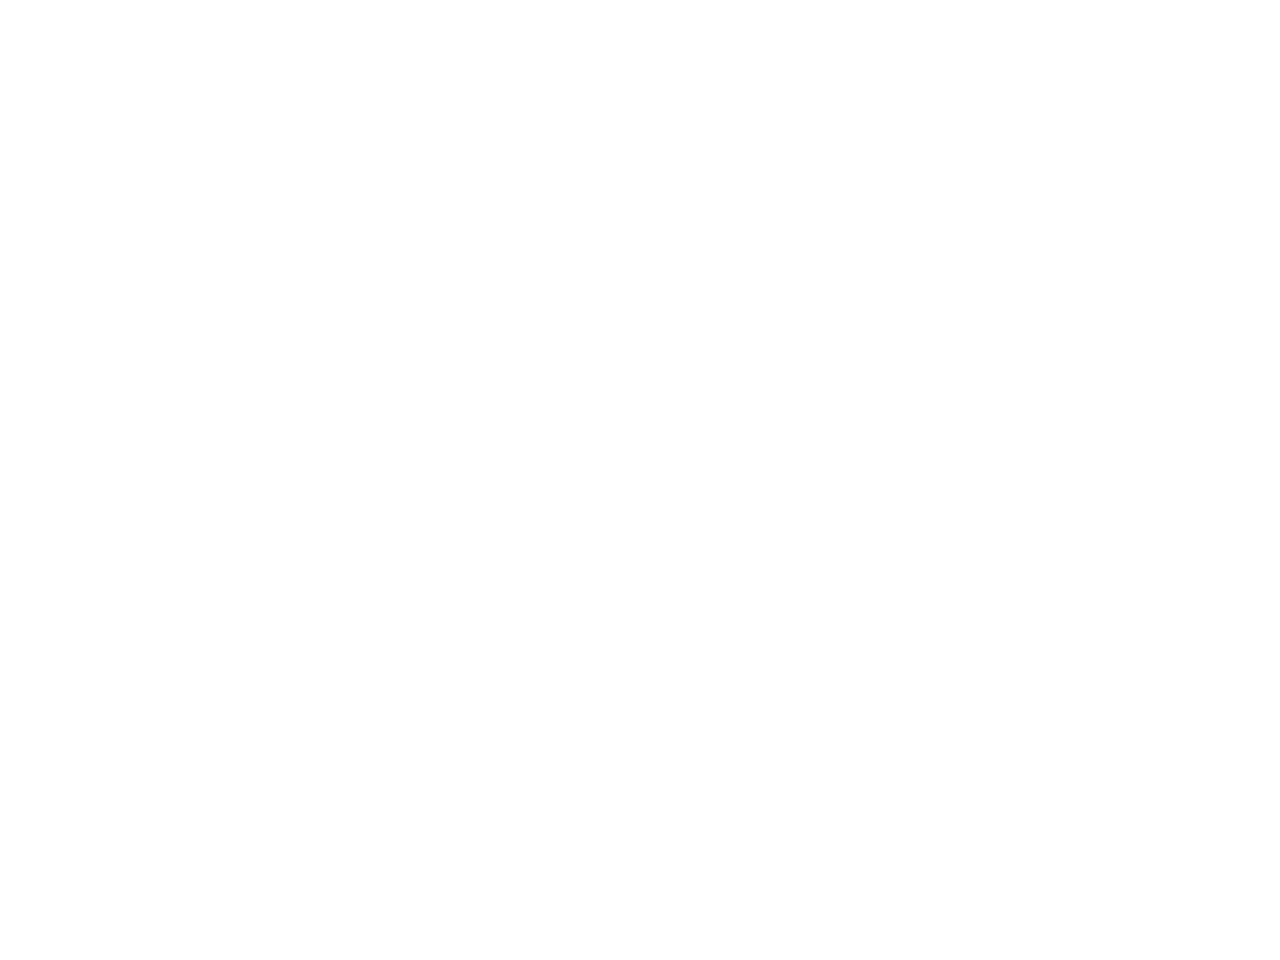

In [23]:
%matplotlib notebook
%matplotlib notebook

# Plot attacker rtt vs time

ax = None
x="sent_time_ms"
y="attacker_to_receiver_ms"
kind="line"
for coap_code in adbgdf["coap_code"].unique():
    if coap_code is None:
        continue
    _df = adbgdf[adbgdf["coap_code"] == coap_code]
    ax = _df.plot(kind=kind, x=x, y=y, ax=ax, label=coap_code)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

<IPython.core.display.Javascript object>


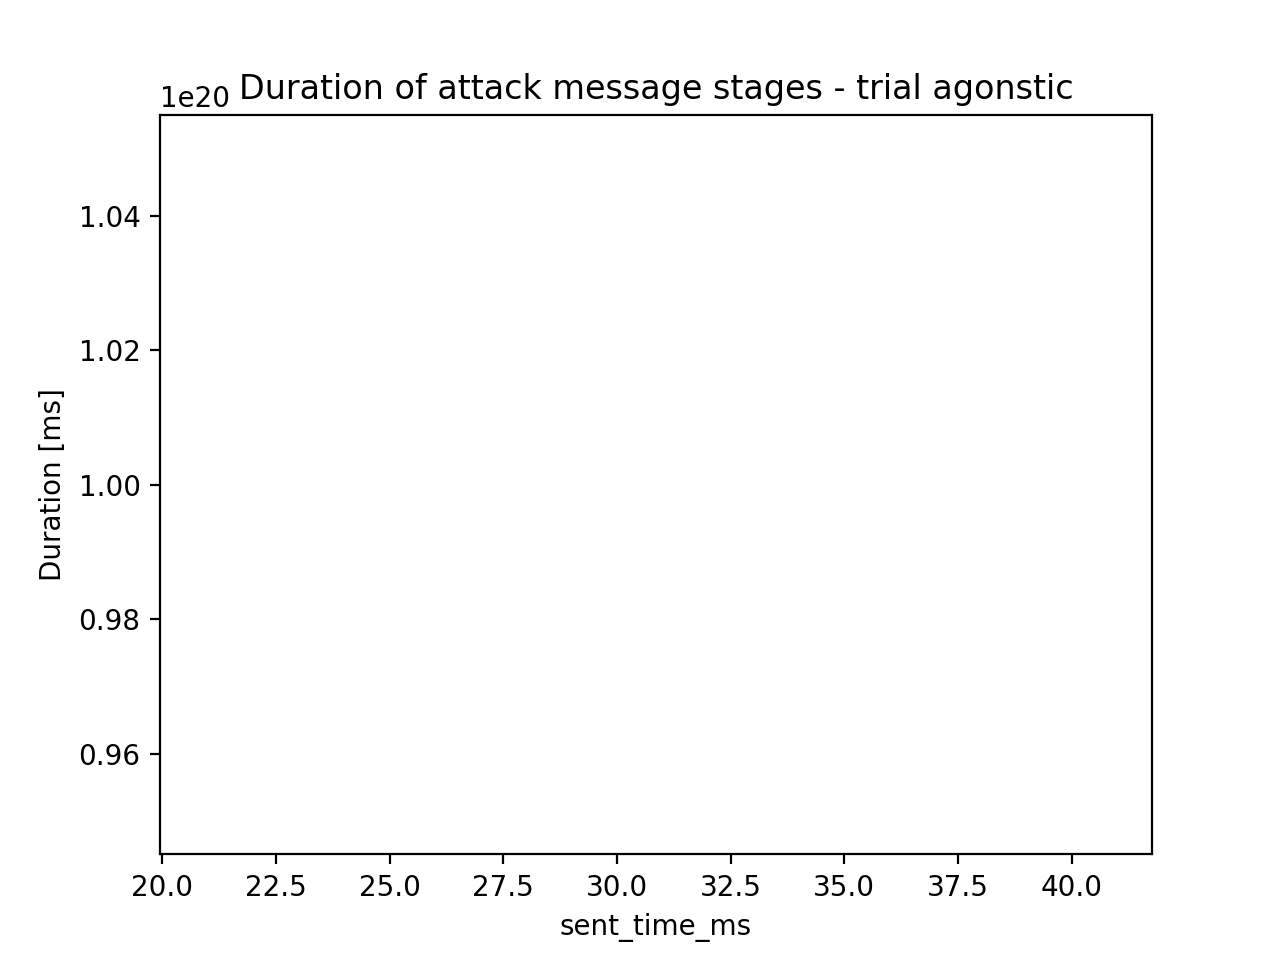

In [24]:
%matplotlib notebook
%matplotlib notebook

# Plot the duration of different stages of the attack messages

x="sent_time_ms"
kind="scatter"
ax = None
ax = adbgdf.plot(kind=kind, x=x, y="attacker_to_proxy_ms", ax=ax, color='red')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_server_ms", ax=ax, color='green')
ax = adbgdf.plot(kind=kind, x=x, y="server_to_proxy_ms", ax=ax, color='blue')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_receiver_ms", ax=ax, color='black')

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agonstic")

plt.show()